# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Lab 2: Clustering Part 2 & Bayesian Intro

**Harvard University**<br>
**Spring 2024**<br>
**Instructors:** Pavlos Protopapas & Alex Young<br>

In [1]:
from sklearn.datasets import make_blobs
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances, silhouette_score, silhouette_samples
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from gap_statistic.optimalK import OptimalK

## Table of Contents  <a id='top'></a>
#### Clustering Part 2
1. [DBSCAN](#dbscan)
    - motivation
    - selecting `min_samples` and `eps`
1. [Penguin Clustering Example](#penguins)
1. [Visualizing High Dimensional Data](#PCA)
1. [Clustering Image Data](#cluster-images)
#### Intro to Bayesian Analysis
1. [Deriving Bayes' Theorem](#bayes1)
1. [Understanding the Terms](#bayes2)
    - prior
    - likelihood
    - evidence
    - posterior
1. [Bayesian Analysis Example](#bayes3) 
    1. Probability Model
    2. Pick a prior
    3. Calculate likelihood
    4. Calculate posterior
    5. Summarize the posterior
1. [Posterior Predictive](#bayes4)

## DBSCAN <a id='dbscan'></a>

[back to table of contents](#top)

[A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise (Ester et al., 1996, KDD-96)](https://www2.cs.uh.edu/~ceick/7363/Papers/dbscan.pdf)

* can find any shape of clusters (compare to $k$-means)
* identifies observations that do not belong to clusters as outliers
* does not require specifying the number of clusters up-front (similar to hierarchical clustering)
* can be used for predicting cluster membership for new data

We'll use some synthetic data to demonstrate scenarios when DBSCAN outperforms other methods.

In [2]:
from sklearn.datasets import make_moons

In [3]:
X, y = make_moons(n_samples=750, noise=.025, random_state=109, )
X = StandardScaler().fit_transform(X)

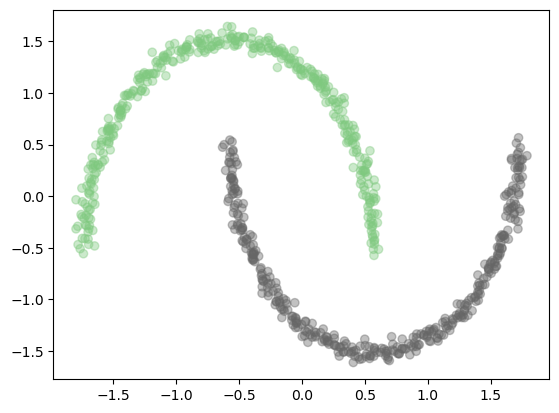

In [4]:
plt.scatter(*X.T, alpha=0.4, c=y, cmap=plt.cm.Accent);

In [5]:
from sklearn.cluster import DBSCAN

[sklearn.cluser.**DBSCAN**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

Let's compare the results of $k$-means and DBSCAN on this dataset.

💡Notice that we don't specify the number of clusters anywhere with DBSCAN

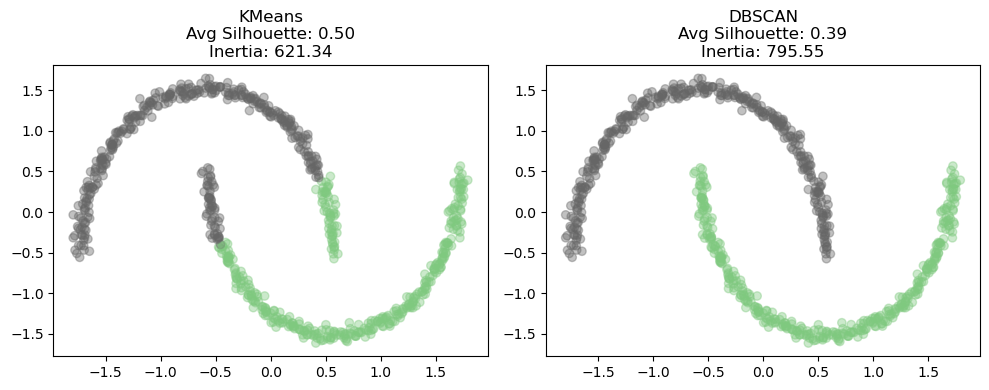

In [6]:
labels = {}
labels['KMeans'] = KMeans(n_clusters=2, n_init=50, random_state=109).fit(X).labels_
labels["DBSCAN"] = DBSCAN(eps=0.12, min_samples=7).fit(X).labels_

# helper funtions
def inertia(X, centroids, labels):
    return sum([((X[labels==i]-centroids[i])**2).sum() for i in np.unique(labels)])
    
def get_centroids(X, labels):
    return np.array([X[labels==k_i].mean(axis=0) for k_i in np.unique(labels)]) 
    
fig, axs = plt.subplots(1,2, figsize=(10,4))
for (title, cur_labels), ax in zip(labels.items(), axs):
    ax.scatter(*X.T, alpha=0.4, c=cur_labels, cmap=plt.cm.Accent)
    ax.set_title(f'{title}\n'+\
                 f'Avg Silhouette: {silhouette_score(X, cur_labels):.2f}\n'+\
                 f'Inertia: {inertia(X, get_centroids(X, cur_labels), cur_labels):.2f}')
plt.tight_layout()

In [7]:
pd.Series(labels['DBSCAN']).value_counts()

0    375
1    375
Name: count, dtype: int64

**Q:** How would you rank the clustering methods based on the **plots**?

**Q:** How would you rank the clustering methods based on the **metrics**?

**Q:** What do you conclude from this discrepancy?

**Q:** How does changing the `n_samples` and `noise` parameters of `make_moons` affect DBSCAN's results.

### Tuning DBSCAN's hyperparameters

In [8]:
from sklearn.neighbors import NearestNeighbors

The most important parameters of the `DBSCAN` constructor are:
* `eps` - radius of a 'neighborhood' around a point
* `min_points` - min number of points required to be within `eps` of a given point for it to be considered a core point.

<img src='img/DBSCAN1.png' width="150"></img>\
If `min_points` is $\leq 6$, then $x$ is a 'core point' in the above example.


<img src='img/DBSCAN2.png' width="200"></img>\
$x$ is a core point (at least `min_points` within `eps`), $y$ is a border point (at least 1 core point within `eps`), and $z$ is a noise point (no core point within `eps`).

Normally `min_points` is selected by a rule of thumb (~5-10) but can depend on your understanding of the density of your data.

To choose `eps` we look at where distances to the $N$-th neighbor among points undergo a big jump. Here $N$ would be set to our choice of `min_points`.

Sklearn's `NearestNeighbors` makes this easy for us.

In [9]:
min_points = 7
nn = NearestNeighbors(n_neighbors=min_points, metric='euclidean').fit(X)

In [10]:
distances, index = nn.kneighbors(X)

Distances to the nearest neighbors.

In [11]:
distances

array([[0.        , 0.01859834, 0.02078963, ..., 0.02082125, 0.02637818,
        0.03968211],
       [0.        , 0.02220057, 0.02697386, ..., 0.03145941, 0.03224509,
        0.03920193],
       [0.        , 0.04107819, 0.06006725, ..., 0.08409831, 0.08755691,
        0.09472645],
       ...,
       [0.        , 0.01315588, 0.03536417, ..., 0.04135997, 0.04262407,
        0.04705254],
       [0.        , 0.03112487, 0.0328174 , ..., 0.04532168, 0.04542927,
        0.05945553],
       [0.        , 0.01641179, 0.02549925, ..., 0.03501536, 0.03734193,
        0.0451489 ]])

And indices of those neighbors.

In [12]:
index

array([[  0, 156, 246, ..., 616, 741, 409],
       [  1, 722, 595, ..., 483, 644, 737],
       [  2, 219, 558, ..., 655, 323, 710],
       ...,
       [747,   9, 335, ..., 618, 289, 643],
       [748, 202, 573, ..., 313, 615, 430],
       [749, 153, 259, ..., 705, 585, 658]])

For our purposes, we only need the distances.

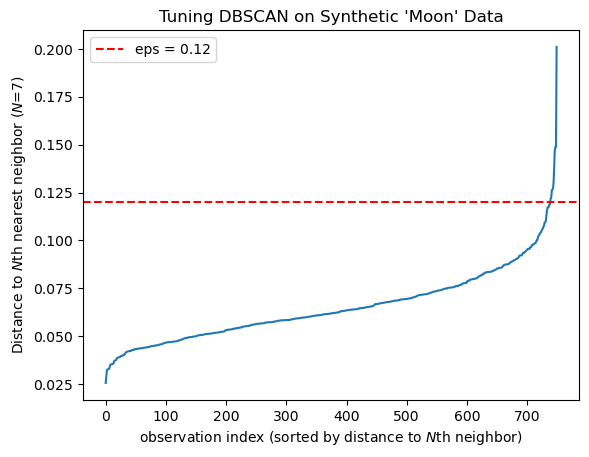

In [13]:
plt.plot(range(distances.shape[0]), np.sort(distances[:,-1]))
eps = 0.12
plt.axhline(eps, ls='--', c='r', label=f"eps = {eps}");
plt.xlabel('observation index (sorted by distance to $N$th neighbor)') 
plt.ylabel(f'Distance to $N$th nearest neighbor ($N$={min_points})')
plt.title("Tuning DBSCAN on Synthetic 'Moon' Data")
plt.legend();

We decide on an `eps` and instantiate and fit our DBSCAN object.

In [14]:
dbscan = DBSCAN(min_samples=min_points, eps=eps).fit(X)

Getting labels from the fitted DBSCAN object works the same as we saw for KMeans.

In [15]:
pd.Series(dbscan.labels_).value_counts()

0    375
1    375
Name: count, dtype: int64

### Visualizing the DBSCAN Algorithm

This page generates DBSCAN animations that can help improve our intuition as to what it is doing:
https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

## Recap: Clustering Penguins? <a id='penguins'></a>

[back to table of contents](#top)

Let's do a quick recap by attempting to cluster the 'penguins' dataset provided in `seaborn`.

<img src='img/penguins.jpg' width='300'></img>

In [16]:
penguins_df = sns.load_dataset('penguins')
penguins_df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Just a little preprocessing...

In [17]:
# drop rows with missing values
penguins_df = penguins_df.dropna().reset_index(drop=True)
X = penguins_df.copy()
# some categorical features need to be numerically encoded...
cat_calls = ['species', 'island', 'sex']
# ...but let's drop some to make the clustering more interesting!
to_drop = ['species', 'island', 'sex']
# get dummies for any categorical features we decided not to drop (if any)
dummy_cols = list(set(cat_calls) - set(to_drop))
X = pd.get_dummies(X.drop(to_drop, axis=1),
                       columns=dummy_cols, drop_first=True)
X = X.values

If we're going to be measuring similarity between observations based on some distance metric we should standardize the features so they are treated equally by the metric.

In [18]:
X_std = StandardScaler().fit_transform(X)

Can we tune **DBSCAN** to get a reasonable clustering on our penguins data?

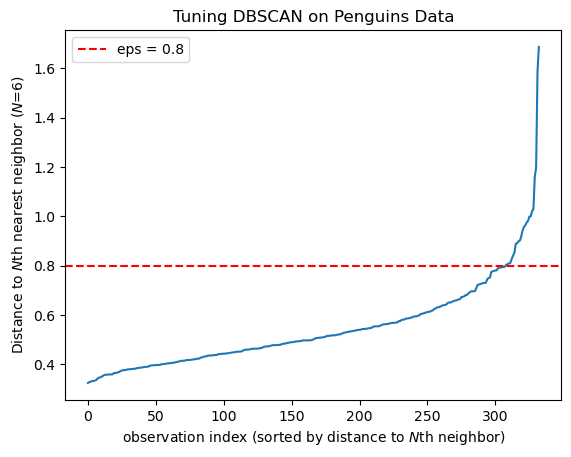

In [19]:
min_points = 6
eps = .8
nn = NearestNeighbors(n_neighbors=min_points, metric='euclidean').fit(X_std)
distances, index = nn.kneighbors(X_std)

plt.plot(range(distances.shape[0]), np.sort(distances[:,-1]))
plt.axhline(eps, ls='--', c='r', label=f"eps = {eps}");
plt.xlabel('observation index (sorted by distance to $N$th neighbor)') 
plt.ylabel(f'Distance to $N$th nearest neighbor ($N$={min_points})')
plt.title("Tuning DBSCAN on Penguins Data")
plt.legend();

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

In [21]:
dbscan = DBSCAN(eps=eps, min_samples=min_points).fit(X_std)

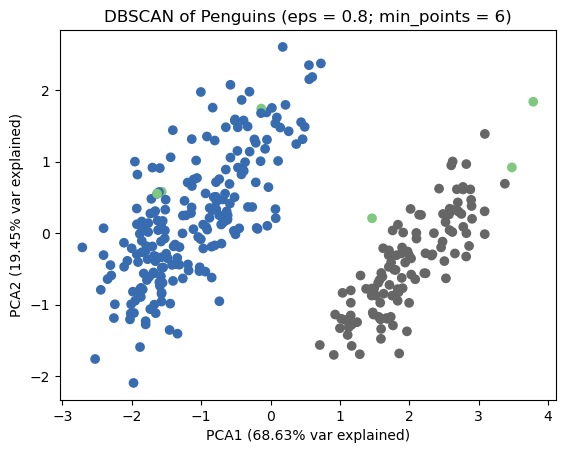

In [22]:
plt.scatter(*X_pca.T, c=dbscan.labels_, cmap=plt.cm.Accent);
plt.xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]:.2%} var explained)")
plt.ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]:.2%} var explained)")
plt.title(f'DBSCAN of Penguins (eps = {eps}; min_points = {min_points})');

**Q**: What do you think of this clustering? What might be an issue for DBSCAN with this data?

**Q**: How many clusters are shown in the plot above?

In [23]:
pd.Series(dbscan.labels_).value_counts()

 0    211
 1    116
-1      6
Name: count, dtype: int64

In fact, **$k$-means** actually does fairly well here.

In [24]:
# get inertias and silhouette scores for many ks
ks = range(1,21)
kms = {k: KMeans(n_clusters=k, n_init=25).fit(X_std) for k in ks}

inertias = [kms[k].inertia_ for k in ks]
sil_scores = [silhouette_score(X_std, kms[k].labels_) for k in ks[1:]]
sil_scores.insert(0,0)

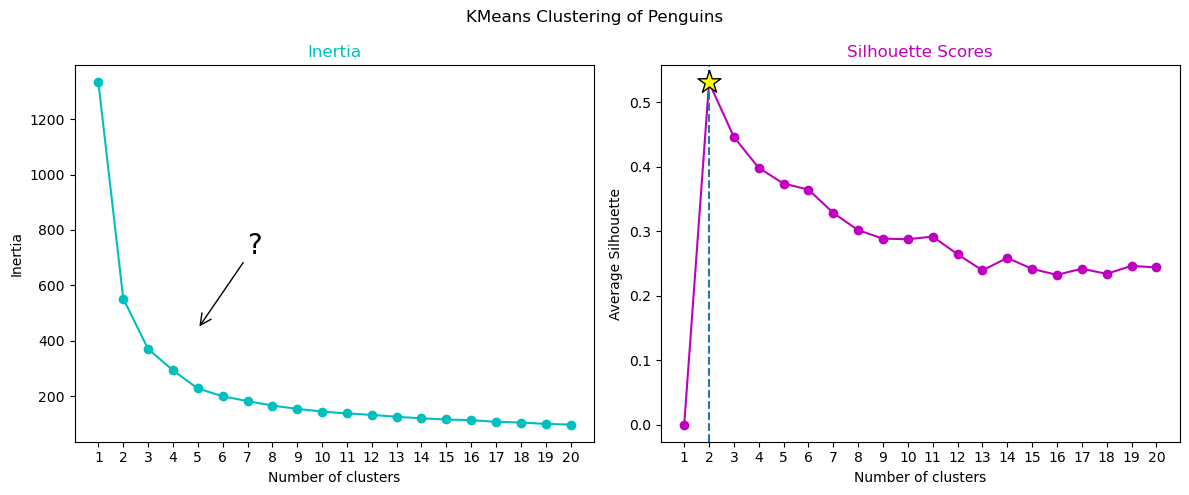

In [25]:
# plot cluster metrics as a function of k
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].plot(ks, np.array(inertias), 'o-c')
axs[0].set_ylabel('Inertia')
axs[0].set_title('Inertia', color='c')
ylim = axs[0].get_ylim()
yrange = ylim[1] - ylim[0]
axs[0].annotate('?', (5, ylim[0]+yrange*.3), (7,ylim[0]+yrange*.5), fontsize=20, arrowprops=dict(arrowstyle='->'))

axs[1].plot(ks, np.array(sil_scores), 'o-m')
axs[1].set_ylabel('Average Silhouette')
axs[1].set_title('Silhouette Scores', color='m')
axs[1].axvline(ks[np.argmax(sil_scores)], ls='--')
axs[1].scatter(ks[np.argmax(sil_scores)], max(sil_scores),
               marker='*', s=300, zorder=4, c='yellow', edgecolor='k')
plt.suptitle(f'KMeans Clustering of Penguins')
for ax in axs:
    ax.set_xlabel('Number of clusters')
    ax.set_xticks(ks);
plt.tight_layout()

In [ ]:
optk = OptimalK(n_jobs=1, clusterer_kwargs={'seed': 42}, random_state=42)
k = optk(X_std, n_refs=100, cluster_array=ks)

In [ ]:
optk.plot_results()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,6), sharey=True)

# easy eay to map categorical strings to and from ints
labenc = LabelEncoder().fit(penguins_df.species)
axs[0].scatter(*X_pca.T, c=kms[k].labels_, cmap=plt.cm.Accent);
# axs[0].scatter(*X_pca.T, c=labenc.transform(penguins_df.species), cmap=plt.cm.Accent);
axs[0].set_xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]:.2%} var explained)")
axs[0].set_ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]:.2%} var explained)")
axs[0].set_title(f'KMeans Clustering ($k = ${k})');


# plot actual species
plt.scatter(*X_pca.T, c=labenc.transform(penguins_df.species), cmap=plt.cm.Accent);
axs[1].set_xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]:.2%} var explained)")
axs[1].set_title(f'Actual Species')
plt.suptitle('Penguins Data');

## Visualizing higher dimensional data (PCA review) <a id='PCA'></a>

[back to table of contents](#top)

In this next section we'll try clustering image date.\
The dataset consists of 1,797 8x8, grayscale images of hand-drawn digits.\
We can still treat images as tabular data. The original 2D matrix of pixel values is flattened into a vector of length 64. Each pixel intensity is a feature.

In [ ]:
X, y = load_digits(return_X_y=True)

In [ ]:
X.shape

In [ ]:
plt.imshow(X[5].reshape(int(np.sqrt(X.shape[1])), -1), cmap='gray');

We also have the labels for each observation in the $y$ vector

In [ ]:
y[:10]

But we cannot visualize a 64 dimensional feature space!

We could throw away some predictors, but if we retained only 2 or 3 pixel values from each image we will have lost almost all of the information.

Instead, we can use Principal Component Analysis (PCA) to find 2 orthogonal vectors in the feature space that have the highest variance.\
We can then project our data onto the 2D subspace, retaining as much information as possible.


#### PCA with SKLearn

To calculate the principal components you *could* use the eigenvector decomposition on the feature covariance matrix or singular value decomposition (SVD) on the original data matrix, but SKLearn provides a helpful`PCA` class.
You can calculate the principle components (`fit`) and project the data onto the space spanned by the components (`transform`).\
You can also do both at once with `fit_transform`.

Here we generate a well-labeled plot of the digits data projected onto its first 2 priciple components.

In [ ]:
# sklearn centers the data for you 'under the hood'
pca = PCA(n_components=2).fit(X)
digits_PCA = pca.transform(X)

plt.scatter(digits_PCA[:,0], digits_PCA[:,1], c=y);
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)')
plt.title('Hand-written Digits Projected onto First 2 Principal Components');

## Clustering Image Data <a id='cluster-images'></a>

[back to table of contents](#top)

In this situation we will actually *not* standardize our data. This is not uncommon with image data as pixel values usually take on a fixed range of values.\
(It also happened to produce the highest average silhouette scores across values of $k$. Standardizing seemed to result in more negative silhouette scores).

In [ ]:
# X_norm = MinMaxScaler().fit_transform(X)
# X_std = StandardScaler().fit_transform(X)
ks = range(2,21)
clusterers = [KMeans(k, random_state=109, n_init=5).fit(X) for k in ks]

Let's look at **inertia** as a function of $k$.

In [ ]:
plt.plot(ks, [c.inertia_ for c in clusterers])
plt.xticks(ks)
plt.xlabel('$k$')
plt.ylabel('inertia')
plt.title('Digit Images Clustered /w KMeans\nInertia');

Hmm... there is a slight bend at $k=9$...\
What does the **silhouette** score suggest?

In [ ]:
sil_scores = [silhouette_score(X, c.labels_) for c in clusterers]

In [ ]:
plt.plot(ks, sil_scores)
plt.axvline(ks[np.argmax(sil_scores)], c='r', ls='--')
plt.xticks(ks);
plt.xlabel('$k$')
plt.ylabel('average silhouette score')
plt.title('Digit Images Clustered /w KMeans\nSilhouette');

Surprisingly, both methods suggest 9 clusters rather than 10 (though the signal from inertia is admittedly very weak).

In [ ]:
# This is the KMeans object that had the best silhouette score
best_clusterer = clusterers[np.argmax(sil_scores)]

Let's now take a look at the both the labeled data in the PCA space as well as the silhouette scores for observations across clusters.

In [ ]:
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters
    cluster_labels = clusterer.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    # axes will be first 2 PCA components
    pca = PCA(n_components=2).fit(X)
    X_pca = pca.transform(X) 
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X_pca[:, 0]
    ys = X_pca[:, 1]    

    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters (transform to PCA space for plotting)
    centers = pca.transform(clusterer.cluster_centers_)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)")
    ax2.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[0]:.2%} variance explained)")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

In [ ]:
silplot(X, best_clusterer)

We can can see that some clusters have observations with negative silhouette scores.

Finally, let's look at the observations that have the worst silhouette scores, suggesting they are in the wrong cluster or otherwise strange in some way.

In [ ]:
# get silhouette scores for all data points
all_sil_scores = silhouette_samples(X, best_clusterer.labels_)

# get in indexs the datapoints in order of worst first
worst_idxs = all_sil_scores.argsort()

In [ ]:
# inspect observations with poor silhouette scores

fig, axs = plt.subplots(2,5, figsize=(9,10))
for idx, ax in zip(worst_idxs, axs.ravel()):
    ax.imshow(X[idx].reshape(8,8), cmap='gray')
    ax.set(xticks=[], yticks=[])
    label = best_clusterer.labels_[idx]
    counts = pd.Series(y[best_clusterer.labels_ == label]).value_counts()
    ax.set_title(f'True Label: {y[idx]}\nAssigned: Cluster {label}\nComposition:\n{counts}')
plt.tight_layout()

**Q:** What do this results suggest? Might it have something to do with the *kinds* of clusters that KMeans produces?

In the next lab we'll look at other clustering algorithms that may capture structure in this dataset that eludes KMeans.

## Introduction to Bayesian Analysis

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, gamma
import matplotlib.pyplot as plt

## Deriving Bayes Theorem <a id='bayes1'></a>

[back to table of contents](#top)

The Bayes' Theorem is

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$

But where did this come from and what is its significance?

As to its origin, Bayes' Theorem can be derived from the definition of **conditional probability**:

$$
P(A|B) = \frac{P(A, B)}{P(B)}
$$

Read as "the probability of $A$ given $B$ is equal to the probability of $A$ *and* $B$ divided by the probability of $B$."

Dividing both sides by $P(B)$, we can issolate the joint probability, $P(A,B)$, on one side:
$$
P(A,B) = P(A|B)P(B)
$$

The joint probability of $A$ and $B$ is symetric: $P(A,B) = P(B,A)$

And so, again starting from the definition of conditional probability:
$$
\begin{align}
P(A|B) &= \frac{P(A,B)}{P(B)}\\
&= \frac{P(B,A)}{P(B)}\\
&= \frac{P(B|A)P(A)}{P(B)}
\end{align}
$$
Which is Bayes' Theorem!

## Understanding the Terms <a id='bayes2'></a>

[back to table of contents](#top)

Here's Bayes' Theorem again on one line:

$$
P(A|B) = \frac{P(B|A) P(A)}{P(B)}
$$

In the context of Bayesian inference, the $A$ above has the interpretation of the parameter(s) of some data generating distribution and $B$ is some observed data generated by the distribution parameterized by $A$.

In other words, Bayesian inference revolves around updating our beliefs or hypotheses in light of new evidence or data. 

$$
P(\text{ parameters }| \text{ data }) = \frac{P( \text{ data } | \text{ parameters }) P(\text{ parameters })}{P( \text{ data })}
$$

Using the notation from lecture we can write this more succinctly as:

$$
P(\theta|Y = y) = \frac{P(Y = y|\theta) P(\theta)}{P(Y = y)}
$$

What's with the $Y=y$? Well, the possible data we *could* observe is a random variable ($Y$). The data we *actually* observed is fixed ($y$).

Central to this are four terms: likelihood, prior, evidence, and posterior. Each plays a critical role in Bayes' Theorem, which is mathematically represented as:

$$
\textbf{Posterior} = \frac{\textbf{Likelihood } \times \textbf{ Prior} }{\textbf{Evidence}}
$$


The denominator (evidence) only depends on $B$ which we are conditioning on, so we can treat it as a constant.\
This allows us to write:

$$
\textbf{Posterior} \propto \textbf{Likelihood} \times \textbf{ Prior} 
$$

Read as "the posterior is proportional to the likelihood times the prior." 

### Likelihood: $P(\text{data} \,|\, \text{parameters})$

The **Likelihood** is a function that measures how well our data supports each possible value of the parameters. It's the probability of observing our data given the parameters. In statistical modeling, it reflects how likely the observed data is for different parameter values.

### Prior: $P(\text{parameters})$

The **Prior** represents our beliefs about the parameters before observing any data. It's a probability distribution that encapsulates our understanding or assumptions about the parameters, independent of the current data. This can come from previous studies, expert opinion, or could be a subjective belief.

### Evidence: $P(\text{data})$

The **Evidence**, also known as the marginal likelihood, is the probability of observing the data under all possible values of the parameters. It's a normalizing constant in Bayes' Theorem, ensuring that the posterior probabilities sum to one. While important theoretically, it's often computationally challenging to calculate directly.

### Posterior: $P(\text{parameters} \,|\, \text{data})$

The **Posterior** is the updated belief about our parameters after observing the data. It combines our prior beliefs with the likelihood of the observed data to form a new probability distribution. This posterior becomes the new state of our knowledge about the parameters, incorporating both prior information and the evidence provided by the data.

## Example: Binomial-Beta Conjugate Prior Model

In this example, we'll explore Bayesian inference using a Binomial-Beta conjugate prior model. The context is to assess Alex's ability to distinguish between regular and decaffeinated coffee.

### Context

Suppose Alex claims he can differentiate between regular and decaffeinated coffee. To test this, we conduct an experiment where Alex is given several cups of coffee, randomly chosen to be either regular or decaffeinated, and he has to identify each type.

### Modeling the Problem

#### Likelihood: Binomial Distribution

- **Model Choice**: We model Alex's guesses as a Binomial distribution. This is because each guess is a binary outcome (correct or incorrect), fitting the Binomial model of 'n' independent Bernoulli trials.
- **Why Binomial?**: The Binomial distribution is chosen for the likelihood because it's ideal for modeling the number of successes in a fixed number of independent experiments (in this case, coffee identification trials).

#### Prior: Beta Distribution

- **Model Choice**: We use a Beta distribution for the prior. The Beta distribution is a continuous distribution defined on the interval $[0,1]$, making it suitable for modeling a probability (in this case, Alex's accuracy).
- **Why Beta?**: The Beta distribution is chosen for the prior because of its conjugate relationship with the Binomial distribution. This means that when a Binomial likelihood is combined with a Beta prior, the posterior distribution is also a Beta distribution.
- **Conjugate Prior**: A conjugate prior simplifies Bayesian updating by ensuring that the posterior distribution belongs to the same family as the prior distribution, making calculations more straightforward.

#### Bayesian Inference

- **Updating Beliefs**: We start with a prior belief about Alex's ability (Beta distribution). After observing the data from the experiments (Binomial likelihood), we update our belief to obtain a posterior distribution.
- **Prior to Posterior**: The initial Beta prior, combined with the Binomial likelihood, yields a new Beta posterior. This posterior reflects our updated belief about Alex's ability after considering the experimental evidence.

#### Mathematical Formulation

If Alex is given $n$ cups of coffee and correctly identifies $k$ of them, and our prior belief about his accuracy is Beta($\alpha, \beta$), then our posterior belief will be $\text{Beta}(\alpha + k, \beta + n - k$).

### Interpretation

- **Before Experiment**: Our belief about Alex's ability is represented by the Beta($\alpha, \beta$) distribution. 
- **After Experiment**: Observing Alex's performance updates our belief, now represented by the Beta($\alpha + k, \beta + n - k$) distribution.
- **Conjugate Prior Advantage**: The use of a conjugate prior (Beta) with a Binomial likelihood makes the Bayesian updating process computationally simpler, allowing for easy calculation of the posterior distribution.

## Demonstrating Conjugacy: Beta-Binomial Model

The Beta-Binomial conjugacy is a classic example in Bayesian statistics, showcasing how the posterior distribution remains in the same family as the prior distribution. Let's demonstrate this with mathematical formulation.

### Problem Setup

We want to determine the probability of success (e.g., correctly identifying coffee type) in a series of Bernoulli trials (e.g., coffee tests). We use a Binomial likelihood and a Beta prior.

### Binomial Likelihood

The likelihood for observing $k$ successes in $n$ trials, given a success probability $\theta$, is given by the Binomial distribution:

$$ P(X = k | \theta, n) = \binom{n}{k} \theta^k (1 - \theta)^{n-k} $$

### Beta Prior

The Beta distribution is used as the prior for $\theta$. It is parameterized by two positive shape parameters, $\alpha$ and $\beta$:

$$ P(\theta | \alpha, \beta) = \frac{\theta^{\alpha - 1} (1 - \theta)^{\beta - 1}}{B(\alpha, \beta)} $$

where $B(\alpha, \beta)$ is the Beta function, a normalization constant.

### Posterior Calculation

The posterior is proportional to the product of the likelihood and the prior:

$$ P(\theta | X, \alpha, \beta) \propto P(X = k | \theta, n) \times P(\theta | \alpha, \beta) $$

Substituting the expressions for the likelihood and the prior, we get:

$$ \propto \binom{n}{k} \theta^k (1 - \theta)^{n-k} \times \frac{\theta^{\alpha - 1} (1 - \theta)^{\beta - 1}}{B(\alpha, \beta)} $$

Simplifying, we find that the posterior is:

$$ \propto \theta^{k + \alpha - 1} (1 - \theta)^{n - k + \beta - 1} $$

Notice that this is the kernel of a Beta distribution with updated parameters $\alpha' = \alpha + k$ and $\beta' = \beta + n - k$.

### Conclusion

The posterior distribution is a Beta distribution, Beta($\alpha + k, \beta + n - k$), demonstrating the conjugacy between the Beta prior and the Binomial likelihood. This conjugacy simplifies the Bayesian updating process, as the posterior remains in the same family (Beta) as the prior.


## Bayesian Analysis Example: Traffic Accidents <a id='bayes3'></a>

[back to table of contents](#top)

We will be using the traffic accidents example in this lab. The number of traffic accidents in a city per day over a 60-day  period are summarized in the following table:

### Summary:
    1. Probability Model for data
    2. Pick a prior for parameters
    3. Calculate likelihood
    4. Calculate posterior for parameters
    5. Summarize the posterior

### Goals:
(1) Estimate the expected number of accidents in a day

(2) Simualate new data based on our estimation

In [ ]:
# Read Data
data = pd.read_csv("data/accidents.csv")
data.head()

### Step 1: Formulate a probability model for the data



In [ ]:
# let's look at the data first
plt.hist(data["Accidents"])
plt.xlabel("Number of Accidents")
plt.ylabel("Counts")

What distribution you think the number of accidents may follow? What parameters this distribution has?

Let $Y_i =$ number of accident in the $i$th observarion for i = 1, 2, ..., n. 

Recall that the Poisson distribution is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant mean rate and independently of the time since the last event.

The number of accidents in a year can be modelled by Possion Distribution: 

$$P(Y_i = y | \theta) = \frac{\theta^y e^{-\theta}}{y!} $$

Here are some properties of Possion distribution:

$$E(Y) = \theta, Var(Y) = \theta$$


In [ ]:
# Visualize Possion Distribution of different theta

# try different theta here:

theta = 25

# creating a numpy array for x-axis
x = np.arange(0, 100, 1) 
# poisson distribution data for y-axis
y = poisson.pmf(x, mu=theta)
 
# plotting the graph
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("pmf")
plt.title("pmf of Possion Distribution of mean " + str(theta))
plt.show()


### Step 2: Choosing a prior distribution

Usually, this step is hard because it requires some knowledge of the context. We only know $\theta \geq 0$. What distribution you think may be suitable here?

Hint: Some common positive continous distribution: Lognormal Distribution, Chi-Square Distribution, Exponential Distribution, Gamma Distribution. 


One possible choice can be $\textbf{gamma distribution}$, that is $\theta \sim \text{ Gamma}(a, b)$, which has probability density function: 

$$ P(\theta) = \frac{b^a}{\Gamma(a)}\theta^{a-1} e^{-b\theta}$$ 

where the $\Gamma(a)$ is the is the gamma function (you don't need to worry about this!). 

Some properties of Gamma distribution: $E(\theta) = \frac{a}{b}, Var(\theta) = \frac{a}{b^2}$.

In [ ]:
# Visualize Gamma Distribution of different theta
# try different a, b here:

a, b = 10, 2

# creating a numpy array for x-axis
x = np.arange(0, 100, 1) 
# poisson distribution data for y-axis
y = gamma.pdf(x, a, scale=1/b)
 
# plotting the graph
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("pdf")
plt.title("pdf of Gamma Distribution of mean " + str(a/b))
plt.show()


### Step 3: Construct the likelihood function

Use the model we developed in step 1 and do some algebra:

$$
\begin{aligned}
L(\theta |\mathbf{Y}) = P(\mathbf{Y}| \theta) & = \Pi_{i=1}^{n} P(Y_i | \theta) \\
& = \Pi_{i=1}^{n} \frac{\theta^{Y_i} e^{-\theta}}{{Y_i}!} \\
& = \frac{e^{-n\theta} \theta^{\sum_{i=1}^{n} Y_i}}{\Pi_{i=1}^{n} {Y_i}!}
\end{aligned}
$$


### Step 4: Determine the posterior distribution

By Bayes Rule: 
$$
P(\theta | \mathbf{Y}) = \frac{P(\theta) P(\mathbf{Y} | \theta)}{P(\mathbf{Y})} \propto P(\theta) P(\mathbf{Y} | \theta)
$$

Plug in what we got in step 2 and 3:

$$
\begin{aligned}
P(\theta | \mathbf{Y}) & \propto P(\theta) P(\mathbf{Y} | \theta) \\
& \propto \frac{b^a}{\Gamma(a)}\theta^{a-1} e^{-b\theta} \cdot \frac{e^{-n\theta} \theta^{\sum_{i=1}^{n} Y_i}}{\Pi_{i=1}^{n} {Y_i}!}\\
& \propto \theta^{\sum_{i=1}^{n} Y_i} \theta^{a-1} e^{-n\theta} e^{-b\theta} \text{ ( terms without } \theta \text{ can all be viewed as constants)} \\
& \propto \theta^{(a+\sum_{i=1}^{n} Y_i)-1} e^{-(b+n)\theta}
\end{aligned}
$$

Does the last expression look familar to you? 

It is the kernel of a gamma distribution: $\text{Gamma}(a+\sum_{i=1}^{n} Y_i, b+n)$. So the posterior distribution is 
$$ \theta | \mathbf{Y} \sim \text{Gamma}(a+\sum_{i=1}^{n} Y_i, b+n)$$

We started with a gamma prior and got a gamma posterior. The gamma distribution is the $\textbf{conjugate prior}$ for the Poisson sampling model. Choosing the conjugate provides algebric convenience because it gives a closed-form expression for the posterior; otherwise, numerical integration may be necessary. 

### Step 5: Summarizing the posterior distribution

Before we try to summarize the posterior distribution, we still have a problem: **What are the values of a and b?** 
There is no "right" or "wrong" choice of **a** and **b**! We can choose values we think that are suitable. 

Let's try $a=0.1$ and $b=0.1$ here!

Now lets compute some summaries of the posterior:

**Posterior Mean**: weighted mean of prior mean and sample mean

$$E(\theta | \mathbf{Y}) = \frac{a+\sum_{i=1}^{n} Y_i}{b+n} = \frac{b}{b+n} \cdot \frac{a}{b} + \frac{n}{b+n}\cdot \frac{\sum_{i=1}^{n} Y_i}{n}$$

**Posterior Variance**: 
$$Var(\theta | \mathbf{Y}) = \frac{a+\sum_{i=1}^{n} Y_i}{(b+n)^2}$$

In [45]:
# let's look at prior and posterior and how the prior affect the posterior

def plot_gamma(a_prior, b_prior, a_posterior, b_posterior ):
    # creating a numpy array for x-axis
    x = np.arange(0, 50, 0.5)

    # poisson distribution data for y-axis
    y_prior = gamma.pdf(x, a=a_prior, scale=1/b_prior)
    y_posterior = gamma.pdf(x, a=a_posterior, scale=1/b_posterior)
    # plotting the graph
    plt.plot(x, y_prior, label="prior")
    plt.plot(x, y_posterior, label="posterior")
    plt.xlabel("\theta")
    plt.ylabel("pdf")
    plt.title("Prior and Posterior(Gamma Distribution)")
    plt.legend()
    plt.show()

    
n = data.shape[0]
a_prior, b_prior = 20 , 1

a_posterior, b_posterior = a_prior + sum(data["Accidents"]), a_prior + n

plot_gamma(a_prior, b_prior, a_posterior, b_posterior)

NameError: name 'data' is not defined

In [49]:
print("The posterior mean is: ", a_posterior/ b_posterior)

print("The posterior variance is: ", a_posterior/ b_posterior**2)

lb, ub = gamma(a=a_posterior, scale=1/b_posterior).ppf(0.025), gamma(a=a_posterior, scale=1/b_posterior).ppf(0.975)
print(f"The 95% central posterior interval is: ({lb}, {ub})", )

The posterior mean is:  25.177419354838708
The posterior variance is:  0.40608740894901146
The 95% central posterior interval is: (23.94377868964643, 26.44161193308362)


## Posterior Predictive: New Data Simulation <a id='bayes4'></a>

[back to table of contents](#top)

Now we want to simulate some new data points! 

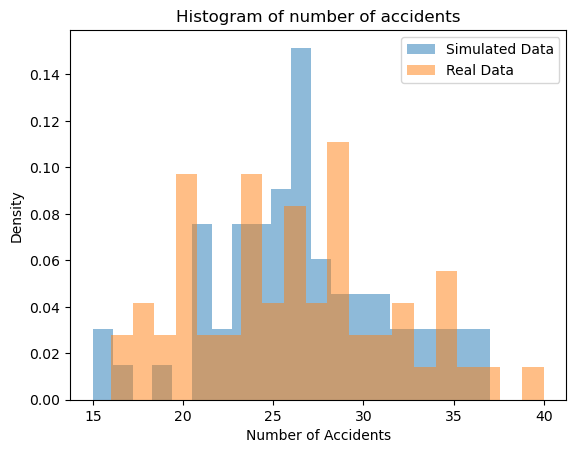

In [50]:
def simulation(n):
    new_data = []
    for i in range(n):
        # todo
        # hint1: which distribution that y should follow?
        # hint2: for the distribution that y follows, what do you know about its parameter?
        theta = np.random.gamma(a_posterior, 1/b_posterior)
        y = np.random.poisson(theta)
        new_data.append(y)
    return new_data
    
new_data = simulation(60)

plt.hist(new_data, bins=20, label="Simulated Data", alpha=0.5, density=True)
plt.hist(data["Accidents"], bins=20, label="Real Data", alpha=0.5, density=True)
plt.legend()
plt.xlabel("Number of Accidents")
plt.ylabel("Density")
plt.title("Histogram of number of accidents");

**The End**